test the build-in model

In [4]:
#import useful libraries
import os
import sys
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input
from skimage import io
import tensorflow as tf
import matplotlib.patches as mpatches
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from functions import *


In [2]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3 
TEST_PATH='./test_set/'# our project
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
n_num=num(dirname='tifs - unanalysed/')
#build our test set
test_ids = next(os.walk(TEST_PATH))[1]
X_test = np.zeros((n_num, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#just to ensure that len of X_test is equal to len of sizes_test
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
n=0
for id_ in tqdm(test_ids, total=len(test_ids)):
    path = TEST_PATH + id_+'/images/'
    dir_3=os.listdir(path)
    k=len(dir_3)
    for i in range(0,k): 
        img = imread(path +dir_3[i])[:,:,:IMG_CHANNELS] # look for all pictures with name Series001
        sizes_test.append([img.shape[0], img.shape[1]])# append sizes of figures i.e. 256*256 pixel: [256,256]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n]=img
        n+=1
print('Done!')

Getting and resizing test images ... 


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]

Done!


In [3]:
#modified from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html
for id_ in tqdm(test_ids, total=len(test_ids)):
    path = TEST_PATH + id_+'/images/'
    dir_3=os.listdir(path)
    k=len(dir_3)
    for i in range(0,k):   
        image = imread(path +dir_3[i])[:,:,:3]# load the pictures
        image = rgb2gray(image) #convert to greyscale after loading
        thresh = threshold_otsu(image) # perform automatic thresholding
        bw = closing(image >thresh,square(3)) #convert 0，1 to bool
        # remove artifacts connected to image border
        cleared = clear_border(bw)
        # label image regions
        label_image = label(cleared)
        # to make the background transparent, pass the value of `bg_label`,
        # and leave `bg_color` as `None` and `kind` as `overlay`
        image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(image_label_overlay)
        for region in regionprops(label_image):
            # take regions with large enough areas
            if region.area >= 150:
                # draw rectangle around segmented coins
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)
        ax.set_axis_off()
        plt.tight_layout()
        figure_save_path ='label_set/'+id_
        if not os.path.exists(figure_save_path):# if directory not exist, create it
            os.makedirs(figure_save_path)   
        plt.savefig(os.path.join(figure_save_path , '{}'.format(dir_3[i])),bbox_inches='tight', pad_inches = -0.1)
        plt.close()
                        

100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


In [4]:
#load the model and use it to make predicted results
model = load_model('model.h5', custom_objects={'mean_iou': tf.keras.metrics.MeanIoU(num_classes=2)})
preds_test = model.predict(X_test, verbose=1)

#Threshold predictions
preds_test_t = (preds_test > 0.8).astype(np.uint8)


6/6 [==============================] - 5s 568ms/step


In [5]:
ID=0
ID_dir={}
for id_ in test_ids:
    path = TEST_PATH + id_+'/images/'
    dir_3=os.listdir(path)
    k=len(dir_3)
    for i in range(0,k): 
        ID_dir[ID]=dir_3[i]
        ID+=1
print(ID_dir)        

{0: '1.2%_1Hour_A-Tubulin.lif - Series001.tif', 1: '1.2%_1Hour_A-Tubulin.lif - Series002.tif', 2: '1.2%_1Hour_A-Tubulin.lif - Series003.tif', 3: '1.2%_1Hour_A-Tubulin.lif - Series004.tif', 4: '1.2%_1Hour_A-Tubulin.lif - Series005.tif', 5: '1.2%_1Hour_A-Tubulin.lif - Series006.tif', 6: '1.2%_1Hour_B-Actin.lif - Series001.tif', 7: '1.2%_1Hour_B-Actin.lif - Series002.tif', 8: '1.2%_1Hour_B-Actin.lif - Series003.tif', 9: '1.2%_1Hour_B-Actin.lif - Series004.tif', 10: '1.2%_1Hour_B-Actin.lif - Series005.tif', 11: '1.2%_1Hour_B-Actin.lif - Series006.tif', 12: '1.2%_1Hour_Caveolin 1.lif - Series001.tif', 13: '1.2%_1Hour_Caveolin 1.lif - Series002.tif', 14: '1.2%_1Hour_Caveolin 1.lif - Series003.tif', 15: '1.2%_1Hour_Caveolin 1.lif - Series004.tif', 16: '1.2%_1Hour_Caveolin 1.lif - Series005.tif', 17: '1.2%_1Hour_Caveolin 1.lif - Series006.tif', 18: '1.2%_1Hour_Clathrin.lif - Series001.tif', 19: '1.2%_1Hour_Clathrin.lif - Series002.tif', 20: '1.2%_1Hour_Clathrin.lif - Series003.tif', 21: '1.2%_

In [6]:
# Perform a sanity check on some random training samples
for i in range(0,len(X_test)):
    plt.figure(figsize=(12,12))
    #plt.subplot(121)
    #plt.imshow(X_test[i])
    #plt.title('original test')
    #plt.axis('off')
    #plt.subplot(122)
    plt.imshow(preds_test_t[i])
    #plt.title('Predictions')
    plt.axis('off')
    #plt.subplot(313)
    #plt.imshow(np.squeeze(preds_test_t[i]))
    #plt.plt.title('Threshold predictions')
    #plt.axis('off')
    plt.tight_layout()
    figure_save_path ='pred_set/'
    if not os.path.exists(figure_save_path):# if directory not exist, create it
        os.makedirs(figure_save_path)   
    plt.savefig(os.path.join(figure_save_path , '{}'.format(ID_dir[i])),bbox_inches='tight', pad_inches = -0.1)
    plt.close()    

[INFO] 14 unique segments found


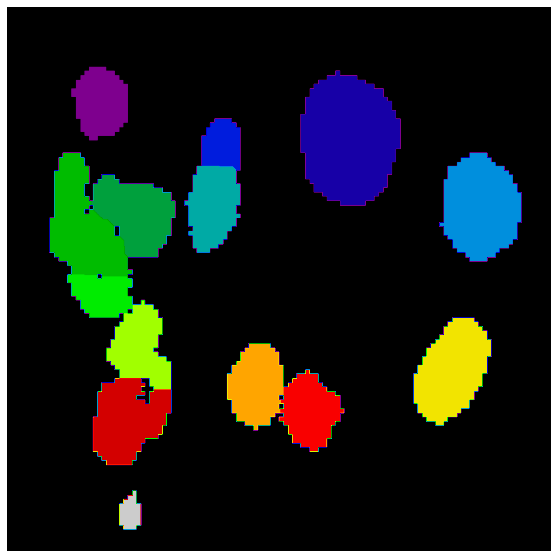

In [6]:
path = './pred_set/'
name=path+'1.2%_1Hour_A-Tubulin.lif - Series005.tif'
sep_count_cells(filename=str(name))

